# Background

English-language folk songs have a long tradition and have changed over time. Songs are not easily idenifiable by name alone, and lyrics often have variations. Steve Roud began indexing his own collection in the 1970s, and his Roud Index has become the standard for grouping together different versions of the same song. He is still indexing as of 2023.

Could a machine learning algorithm hope to match his skill? Given the lyrics, would it choose the same groupings of songs, where the line between "same" and "different" is fuzzy? Could it help with future indexing?

# Data

## Sources

Although the Roud index is a lyrics-based classification system (rather than tune-based), the officially-hosted index at vwml.com does not contain lyric transcriptions as a standard data field. Some lyrics are accessible online, presented in scanned images of historical collections, others on linked external sites, others not at all. 

So the first challenge is to get a dataset with enough full lyrics and Roud numbers in combination. The main contenders for the source of this data are Mudcat and The Traditional Ballad Index, both well-established online song databases.

### Mudcat 
- Project focuses on song lyrics and tunes, but also contains Roud numbers for approximately 300 songs.
- Data and formats:
    - Digitrad (DT) download: askSam MS-DOS database (last updated in 2002)
    - Song web pages
    - Forum posts containing songs

### The Traditional Ballad Index 
- Project focuses on cataloguing*, but also has supplementary lyrics for approximately 1110 songs.
- Data and formats:
    - The Ballad Index Software download: Claris Filemaker database
    - Song web pages (without lyrics)
    - The Ballad Index (BI) and The Supplemental Tradition (ST) (lyrics) as HTML or TXT lists

&ast; This is a similar to approach to Roud, but focused on the basic unit of a song rather than its individual instances (e.g. variations, songbook entries or performances), and therefore uses song titles as its main identifiers, with keywords and first line for disambiguation.


## Extraction

Neither the Ballad Index (which would have included ST lyrics) nor the Mudcat Digitrad downloadable databases will open. 

In order to link Roud numbers to lyrics, I therefore need to work with the `.txt` version of the Ballad Index (which does not include ST) as my base for a new database, extract the records from it, then join ST and DT's lyrics to these records using the various references provided in each data source.

### Linking data: Filenames as keys

To link the lyrics correctly to the main data of the BI, I need fields that act as idenifiers/keys:

#### BI filename
Alphanumeric filename serving as an identifier for all BI records, also referenced by ST lyrics where they exist.

#### DT filename
8.3 filename (all-caps without extension) serving as an identifier for all DT records, also sometimes referenced in BI. 
* Note: in a minority of cases, modified DT filenames also appear to be used as the main BI filenames ('DT' + first six characters in lower or title case), e.g. 'DToatsbe' is the same as 'OATSBEAN' in DT). However, this occasionally disagrees with the stated DT filename for the BI record.

#### Other numbers and references:
**DT number:** Many records in DT and BI also contain a 'DT #'. This number is not the same as the DT file, and, contrary to my first assumption, nor does it correspond to the SongID in Mudcat URLs (e.g. http://mudcat.org/@displaysong.cfm?SongID=329). It appears to be another grouping system developed by Mudcat and intended to extend Child numbers (see below): "*Francis J. Child only went up to 305--since there are ballads he didn't include, you may notice some numbers like DT #510 . Not to worry--it just helps locate variants*".

**Roud number:** Found in BI only (at least as far as downloadable data is concerned - song lyrics on Mudcat's website do often include this).

**Child number:** The Child Ballads were the first large collection of songs of English and Scottish origin collected by Francis James Child in the 1800s. Many songs contained multiple versions. Child  numbers (1-305) are often referenced in folk song sources.

**Laws number:** George Malcolm Laws and the American Folklore Society published a collection of traditional songs in 1957. Laws numbers contain an initial letter which indicates the song's theme, e.g. 'M: Ballads of Family Opposition to Lovers'. Laws numbers are also commonly referenced.

**Other collections:** References to other collections are sometimes found, and some of these also have their own numbers for songs.

### Extraction quantity targets (BI, ST, DT)

Based on text editor finds I estimate I can extract approximately the following data [with comparisons for a Google domain search of online versions]:
- BI: 30445 song record files, of which (in combination):
    - 14213 are stubs for variants that only refer to other songs
    - 2623 refer to DT files (lyrics) [compare: Google search: 357]; 356 have BI filenames referring to a DT filename
    - 1180 refer to ST files (lyrics) [compare: Google search: 395]
    - 12126 of these contain Roud index numbers [compare: Google search: 2700]
- ST: 1229 lyrics referencing 1136 BI files [no separate online version]
- DT: 8932 song record files (lyrics)
    - only 1 contains a Roud number [compare: Google search of newer web version: 435]

## BI (Ballad Index)

Below is a preview of `balldidx.txt`. The text version of the Ballad Index file is tricky to work with as entries are presented as a list with inconsistent headings and mixed data. 

I first used a text editor to place colons before Roud numbers and DT filenames, so that they could be more easily matched. (This could have been perhaps better achieved with regex, although to begin I decided to save myself a step as they were formatted inconsistently.)

Here it is interesting to note that the BI database also references Mudcat's DT filenames, for example 'DT, MASS1913*' above. This means we can also supplement lyrics by cross-referencing this data.

I then used a script with regular expressions to import while doing the following:
- split song records at the marker '==='
- extract only the values for 'name', 'description', 'earliest_date', found_in', 'keywords', 'cross_references', 'roud', 'bi_file', 'st_file', and 'dt_file'
- split and store reference song name and filename information in one-line stub records that only serve to reference a main song
- extract only the earliest year found in the 'EARLIEST_FOUND:' field which contained mixed data
- replace empty fields with NumPy `NaN` to allow for better data manipulation

These are stored in `df_bi`.

Target: 30445 file records |
Output: 30418 file records

In [2]:
#BI extraction (MERGED)
import re
import pandas as pd
import numpy as np

# get file data
file_path = './Data/BalladIndex/txt/BDIDXTXT/balldidxedited.txt'
with open(file_path, 'r') as file:
    data = file.read()

# define record boundary pattern (handle both cases with optional newline)
record_pattern = re.compile(r'(?<=\n)?===\n(.*?)(?=\n===)', re.DOTALL)

# feed pattern and data to a callable iterator to get `records` matches
records = re.finditer(record_pattern, data)

# define the field patterns, including the special pattern for stubs
field_patterns = {
    'name': r'NAME: (.*?)(?:: see |\n|$)',
    'key_name': r'(?<=: see )([^:(\n]*)',  # extract main song for stubs
    'description': r'DESCRIPTION: (.*?)(?:\nAUTHOR: |\nEARLIEST_DATE: |\nKEYWORDS: |\nFOUND_IN: |\nREFERENCES: |\nSAME_TUNE: |\nST: |\nDT: |\nROUD: |\nRECORDINGS: |\nCROSS_REFERENCES: |\nNOTES: |\nLast updated|$)',
    'author': r'AUTHOR: (.*?)(?:\n|$)',
    'earliest_date': r'EARLIEST_DATE: (.*?)(?:\n|$)',
    'long_description': r'LONG_DESCRIPTION: (.*?)(?:\n[A-Z]+: |Last updated|$)',
    'keywords': r'KEYWORDS: (.*?)(?:\n|$)',
    'found_in': r'FOUND_IN: (.*?)(?:\n|$)',
    'references': r'REFERENCES: (.*?)(?:\n[A-Z]+: |Last updated|$)',
    'same_tune': r'SAME_TUNE: (.*?)(?:\n|$)',
    'st_file': r"(?<=\nST: )(.*?)(?=\n)",
    'dt_file': r"(?<=\nDT: )(.*?)(?=\n)",
    'roud': r'ROUD: (.*?)(?:\n|$)',
    'recordings': r'RECORDINGS:\n((?:(?!CROSS_REFERENCES|NOTES|Last updated).)*)(?:\n|$)',
    'cross_references': r'CROSS_REFERENCES:\n((?:(?!NOTES|Last updated).)*)(?:\n|$)',
    'notes': r'NOTES: (.*?)(?:\nLast updated|$)',
    'last_updated': r'Last updated in version (.*?)(?:\n|$)',
    'bi_file': r"File: (.*?)(?=\nNAME:|\n===|\nLast updated|$)"
}

# initialise a list to store dicts of extracted `record_data`
records_data = []

# loop over each of the `records` from the iterator
for record in records:
    # check if it is a stub record
    is_stub = ': see ' in record.group(1)
    if is_stub:
        # handle stub records separately
        stub_data = re.search(r'NAME: (.*?): see (.*?) \(File: (.*?)\)', record.group(1))
        if stub_data:
            name, key_name, bi_file = stub_data.groups()
            record_data = {
                'name': name.strip(),
                'key_name': key_name.strip(),
                'bi_file': bi_file.strip()
            }
    else:
        # iterate over the patterns and `search` them, storing match group 1 with its field in `record_data`
        record_data = {}
        for field, pattern in field_patterns.items():
            value = re.search(pattern, record.group(1))
            if value:
                value = value.group(1).strip()
                # for dates: get earliest year and dump the rest
                if field == 'earliest_date':
                    years = re.findall(r'\b\d{4}\b', value)
                    if years:
                        value = min(map(int, years))
            else:
                value = ""
            record_data[field] = value

    # add each finished record to the list
    records_data.append(record_data)

# make the data into a df, fill empty fields with `NaN`s
df_extracted = pd.DataFrame(records_data)

df_bi = df_extracted[['name', 'key_name', 'keywords', 'description', 'long_description', 'found_in', 'bi_file', 'st_file', 'dt_file', 'roud']].copy()
df_bi.replace('', np.nan, inplace=True)
df_bi.dropna(how='all', inplace=True)
df_bi

,name,key_name,keywords,description,long_description,found_in,bi_file,st_file,dt_file,roud
0,"10,000 Years Ago",I Was Born About Ten Thousand Years Ago (Bragg...,NaN,NaN,NaN,NaN,R410,NaN,NaN,NaN
1,10th MTB Flotilla Song,Fred Karno's Army,NaN,NaN,NaN,NaN,NeFrKaAr,NaN,NaN,NaN
2,13 Highway,NaN,grief love promise nonballad lover technology,"""I went down 13 highway, Down in my baby's doo...",NaN,US(SE),Rc13Hwy,NaN,NaN,29487
3,151 Days,Hundred and Fifty-One Days,NaN,NaN,NaN,NaN,Colq060,NaN,NaN,NaN
4,"1861 Anti Confederation Song, An",Anti-Confederation Song,NaN,NaN,NaN,NaN,FJ028,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30412,Zula,NaN,love rejection separation travel,"""Thou lov'st another, Zula, Thou lovest him al...",NaN,US(So),Brne049,NaN,NaN,11330
30413,"Zulu Warrior, The",NaN,nonballad nonsense campsong,"""I-kama zimba zimba zayo I-kama zimba zimba ze...",NaN,NaN,ACFF061A,NaN,NaN,NaN
30414,Zum Gali Gali,NaN,foreignlanguage campsong,"Hebrew. ""Zum, gali-gali-gali, Zum gali-gali, Z...",NaN,NaN,ACSF314Z,NaN,NaN,NaN
30415,Zutula Dead,NaN,death poison food,A nice girl gave Zutula bitter casava to eat a...,NaN,West Indies(Trinidad),RcALZuDe,NaN,NaN,NaN


### Stub inheritance

Next I want to make stubs inherit Roud number and file references from their parent entries. I do this via a lookup table containing only those 'bi_file' entries that have the other data associated:

In [3]:
# MERGED # make a lookup table where bi_file points to st_file, dt_file and roud
df_file_lookup = df_bi[['bi_file', 'st_file', 'dt_file', 'roud']].dropna(subset=['roud', 'st_file', 'dt_file'], how='all')
df_file_lookup

,bi_file,st_file,dt_file,roud
2,Rc13Hwy,NaN,NaN,29487
5,FSWB306A,NaN,MASS1913*,17663
8,Hopk112,NaN,NaN,29405
11,Hopk039,NaN,NaN,29404
12,Hopk046,NaN,NaN,29403
...,...,...,...,...
30399,San449,San449 (Full),NaN,12174
30403,SuSm091B,NaN,NaN,20694
30405,Dett196,NaN,NaN,15233
30406,Fus214,Fus214 (Partial),NaN,16373


In [4]:
# MERGED fill missing values from lookup table
df_bi['roud'] = df_bi['roud'].fillna(df_bi['bi_file'].map(df_file_lookup['roud']))
df_bi['st_file'] = df_bi['st_file'].fillna(df_bi['bi_file'].map(df_file_lookup['st_file']))
df_bi['dt_file'] = df_bi['dt_file'].fillna(df_bi['bi_file'].map(df_file_lookup['dt_file']))

In [5]:
df_bi

,name,key_name,keywords,description,long_description,found_in,bi_file,st_file,dt_file,roud
0,"10,000 Years Ago",I Was Born About Ten Thousand Years Ago (Bragg...,NaN,NaN,NaN,NaN,R410,NaN,NaN,NaN
1,10th MTB Flotilla Song,Fred Karno's Army,NaN,NaN,NaN,NaN,NeFrKaAr,NaN,NaN,NaN
2,13 Highway,NaN,grief love promise nonballad lover technology,"""I went down 13 highway, Down in my baby's doo...",NaN,US(SE),Rc13Hwy,NaN,NaN,29487
3,151 Days,Hundred and Fifty-One Days,NaN,NaN,NaN,NaN,Colq060,NaN,NaN,NaN
4,"1861 Anti Confederation Song, An",Anti-Confederation Song,NaN,NaN,NaN,NaN,FJ028,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
30412,Zula,NaN,love rejection separation travel,"""Thou lov'st another, Zula, Thou lovest him al...",NaN,US(So),Brne049,NaN,NaN,11330
30413,"Zulu Warrior, The",NaN,nonballad nonsense campsong,"""I-kama zimba zimba zayo I-kama zimba zimba ze...",NaN,NaN,ACFF061A,NaN,NaN,NaN
30414,Zum Gali Gali,NaN,foreignlanguage campsong,"Hebrew. ""Zum, gali-gali-gali, Zum gali-gali, Z...",NaN,NaN,ACSF314Z,NaN,NaN,NaN
30415,Zutula Dead,NaN,death poison food,A nice girl gave Zutula bitter casava to eat a...,NaN,West Indies(Trinidad),RcALZuDe,NaN,NaN,NaN


### Clean and split multiple 'dt_file' entries

Next I need to handle cases where more than one DT filename is associated with each record, to allow for correct data merging later. I will assign the duplicates to new rows, first discarding DT numbers and other characters that do not constitute a valid DT filename.

In [6]:
# MERGED clean up so only valid DT filenames remain, separated by a space
def clean_filenames(df, column_name):
    # reg pattern for valid filenames (5-8 characters, all in capitals)
    pattern = r'\b[A-Z0-9]{5,8}\b'
    
    # function for cleaning each cell
    def clean_cell(cell_value):
        if pd.isna(cell_value):
            return np.nan
        else:
            # find valid filenames in the cell
            matches = re.findall(pattern, cell_value)
            # return them as a space-separated string
            cleaned_value = ' '.join(matches)
            return cleaned_value
    
    # call cleaning function on the column provided in args
    df[column_name] = df[column_name].apply(clean_cell)
    return df

df_bi_cleaned = clean_filenames(df_bi.copy(), 'dt_file')


A visual check suggests the cleaning worked:

In [7]:
df_bi_cleaned[['name', 'bi_file', 'dt_file']].loc[df_bi_cleaned.dt_file.str.contains(' ', na=False)].sort_values(by='dt_file')

,name,bi_file,dt_file
13779,Johnny Fill Up the Bowl (In Eighteen Hundred a...,R227,ABEWASH FORBALES
176,Admiral Benbow (I),PBB076,ADBENBOW ADBENBW2
15110,Let Me In This Ae Nicht,DTaenich,AENICHT COLDRAIN
198,After the Ball,SRW169,AFTRBALL UNFORTU6
223,Aiken Drum,OO2007,AIKDRUM AIKDRUM3
...,...,...,...
28425,"Weaver and the Factory Maid, The",DTwvfact,WVFACTGL WEAVFACT
3176,"Brisk Young Butcher, The",DTxmasgo,XMASGOOS XMASGOO2
22203,"Rare Willie Drowned in Yarrow, or, The Water o...",C215,YARROW2 YARROW3
30179,Young Allan [Child 245],C245,YNGALAN YNGALAN2


Now to split the valid filenames into their own rows and examine the changed rows:

In [8]:
# MERGED split rows
def separate_filenames(df, column_name):
    # empty DataFrame to store the results
    new_df = pd.DataFrame(columns=df.columns)
    
    # function to split the multiple filenames into new rows
    def split_multiple_filenames(row):
        nonlocal new_df
        if pd.notna(row[column_name]):
            filenames = row[column_name].split()
            for filename in filenames:
                new_row = row.copy()
                new_row[column_name] = filename
                new_df = new_df.append(new_row, ignore_index=True)
        else:
            new_df = new_df.append(row, ignore_index=True)  # Include rows with NaN filenames
    
    # apply the splitting function to the define column
    df.apply(split_multiple_filenames, axis=1)
    return new_df

df_bi_separated = separate_filenames(df_bi_cleaned, 'dt_file')

/tmp/ipykernel_52677/3582655141.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)  # Include rows with NaN filenames
/tmp/ipykernel_52677/3582655141.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(new_row, ignore_index=True)


In [9]:
df_bi_separated[df_bi_separated.duplicated(subset='bi_file', 
keep=False)].dropna(subset='dt_file').sort_values(by='dt_file')[['name', 'bi_file', 'dt_file']]

,name,bi_file,dt_file
85,Abdul the Bulbul Emir (II),EM210,ABDULBL2
84,Abdul the Bulbul Emir (I),LxA341,ABDULBUL
48,A-Begging I Will Go,K217,ABEGGIN
14132,Johnny Fill Up the Bowl (In Eighteen Hundred a...,R227,ABEWASH
5795,David's Lamentation,FSWB412B,ABSALON
...,...,...,...
6848,"Drummer Boy of Waterloo, The [Laws J1]",LJ01,YOUNGED
14832,Kingdom Coming (The Year of Jubilo),R230,YRJUBILO
31061,"Zack, the Mormon Engineer",BRaF444,ZACKMORM
31067,"Zebra Dun, The [Laws B16]",LB16,ZEBRADUN


#### Extract DT filenames from BI filenames
The next stage is to extract possible DT filenames from the bi_file entries. I will match these later on the DT data. Of the entries with BI filenames with this 'DTxxxxxx' pattern, 168 are missing DT filenames:

In [10]:
# filter rows where 'bi_file' starts with 'DT' and 'dt_file' is NaN
filtered_rows = df_bi_separated[df_bi_separated['bi_file'].str.startswith('DT', na=False) & df_bi_separated['dt_file'].isna()]
filtered_rows[['name', 'bi_file', 'dt_file']]

,name,bi_file,dt_file
432,Allan Water,DTalanwa,NaN
493,"Altoona Freight Wreck, The",DTwrck12,NaN
1133,B'y' Sara Burned Down,DTBayous,NaN
1188,"Back and Side Go Bare, Go Bare!",DTbcksid,NaN
1387,"Banks of Allen Water, The",DTalanwa,NaN
...,...,...,...
30282,"Winter It Is Past, The",DTcurrki,NaN
30290,Winter's Gone and Past,DTcurrki,NaN
30307,Wise Willie,DTcutywr,NaN
30455,"Wreck at Latona, The",DTwrck12,NaN


I will strip 'DT' from these filenames and insert them in the column DT_file for affected rows:

In [11]:
# fill 'dt_file' with the remainder of the string after 'DT'
df_bi_separated.loc[filtered_rows.index, 'dt_file'] = filtered_rows['bi_file'].str[2:]

df_bi_separated.loc[filtered_rows.index][['name', 'bi_file', 'dt_file']]

,name,bi_file,dt_file
432,Allan Water,DTalanwa,alanwa
493,"Altoona Freight Wreck, The",DTwrck12,wrck12
1133,B'y' Sara Burned Down,DTBayous,Bayous
1188,"Back and Side Go Bare, Go Bare!",DTbcksid,bcksid
1387,"Banks of Allen Water, The",DTalanwa,alanwa
...,...,...,...
30282,"Winter It Is Past, The",DTcurrki,currki
30290,Winter's Gone and Past,DTcurrki,currki
30307,Wise Willie,DTcutywr,cutywr
30455,"Wreck at Latona, The",DTwrck12,wrck12


### Target check:

DT file references:

Target: 2623 | Initial output: 2605 | Post-split: 3264

In [12]:
df_bi_separated.query("dt_file.notna()").dt_file.count()

3432

ST file references:

Target: 1180 | Initial output: 1166 | Post-split: 1200

In [13]:
df_bi_separated.query("st_file.notna()").st_file.count()

1200

Roud references:

Target: 12126 | Initial output: 12004 | Post-split: 12656

In [14]:
df_bi_separated.query("roud.notna()").roud.count()

12656

Unique roud numbers: 11266 (note that this is inaccurate as multiple Roud numbers per field are sometimes still present)

In [15]:
# Number of unique Roud numbers amongst songs that now have lyrics matched:
df_bi_separated.query("roud.notna()").roud.nunique()

11266

The following query shows I would have 3782 songs with Roud numbers and lyrics, if I were to now join up the data and all the referenced lyrics files could be extracted. 

In [16]:
df_lyrics_available = df_bi_separated.query("(st_file.notna() | dt_file.notna()) & roud.notna()")
df_lyrics_available[['name', 'roud', 'bi_file', 'st_file', 'dt_file']].sort_values('roud')

,name,roud,bi_file,st_file,dt_file
10003,"Gypsy Laddie, The [Child 200]",1,C200,NaN,GYPLADD3
10000,"Gypsy Laddie, The [Child 200]",1,C200,NaN,GYPDAVY
10001,"Gypsy Laddie, The [Child 200]",1,C200,NaN,GYPLADD
10002,"Gypsy Laddie, The [Child 200]",1,C200,NaN,GYPLADD2
10011,"Gypsy Laddie, The [Child 200]",1,C200,NaN,GYPLADY
...,...,...,...,...,...
16274,Lord Cornwallis's Surrender,V50597,SBoA088,NaN,LRDCRNWL
17588,"Memory of the Dead, The",V5143,PGa039,NaN,MEMRYDED
25860,"Star-Spangled Banner, The",V5200,MKr015,NaN,STARSPAN
6797,Drive the Cold Winter Away (In Praise of Chris...,V9375,Log293,Log293 (Full),ALLHAIL


This number of songs could even increase if I could match variant lyrics also based on variant titles
or if any new backwards file references to BI files are found in the two lyrics data sources.

I will copy these test modifications into `df_bi` and save to csv for further use.

In [17]:
df_bi = df_bi_separated.copy()

In [18]:
#df_bi.to_csv('./Data/df_bi.csv') #save to CSV

## ST (Supplementary Tradition of BI)

The Supplementary Tradition is the lyrics index of the Ballad Index. Again, I must use regular expressions to extract the data, this time from `supptrad.txt`. This has a different format to the BI. 

The main song title is listed at the head of the records, followed by the type of lyrics [Complete text(s) or Partial text(s)] followed by different versions of the lyrics marked [*** A ***, *** B ***, *** C ***, ...] often preceded by an alternate title and notes about the story and/or provenance of the lyrics.

Due to the aforementioned song-based classification system of the BI, multiple alternate versions are often linked to one BI record file and key title. Later I may want to split the files into different versions, so I will treat the the main song record as a parent ('key_...') and treat the versions as children which will stand as individual records but inherit some values from their parents. Some of the alternate versions do not have their own names.

I want to extract: `key_name`, `key_full_part`, `version_in_key`, `name`, `provenance` [detected to exclude from lyrics], `lyrics`, `bi_file` [this belongs to key/parent but I want to name consistently for later data combinations]

In [19]:
with open('./Data/BalladIndex/txt/supptradedited.txt', 'r') as file:
    data = file.read()
    
def parse_lyric_information(data):
    outer_records = data.split("\n===\n")  # split into outer records
    records_list = []

    for record in outer_records:
        outer_lines = record.strip().split('\n')
        if len(outer_lines) < 2:
            continue  # skip 'records' with insufficient lines

        key_name = None
        key_full_part = None
        bi_file = None

        inner_records = record.strip().split('          *** ')[1:]  # split into inner records

        for i, line in enumerate(outer_lines):
            if line.startswith("==="):
                if i > 0:
                    break  # Stop looking for key_name and key_full_part after the first record
            elif not key_name:
                key_name = line.strip()
            elif not key_full_part:
                key_full_part = line.strip()
            elif not bi_file:
                bi_file_match = re.search(r"File: (.+)", line)
                if bi_file_match:
                    bi_file = bi_file_match.group(1).strip()

        for inner_record in inner_records:
            lines = inner_record.strip().split('\n')
            version_in_key = None
            name = None
            provenance = None
            lyrics = None

            is_in_provenance = False
            provenance_lines = []
            is_in_lyrics = False
            lyrics_lines = []

            for line in lines:
                if not version_in_key and line.strip() and line.strip()[0].isupper():
                    version_in_key = line.strip()[0]
                elif not name and line.strip() and not line.strip().startswith("From ") and not line.strip().startswith("Text ") and \
                        not line.strip().startswith("Derived ") and not line.strip().startswith("As printed ") and \
                        not line.strip().startswith("Supplied ") and not line.strip().startswith("Lyrics ") and \
                        not line.strip().startswith("As found in ") and not line.strip().startswith("As recorded ") and \
                        not line.strip().startswith("Also from ") and not line.strip().startswith("Also supplied") and \
                        not line.strip().startswith("Derived from "):
                    if name is None:
                        name = line.strip()
                elif not provenance and re.match(r"^(From |Text |Derived |As printed |Supplied |Lyrics |As found in |As recorded |Also from |Also supplied|Derived from )", line):
                    is_in_provenance = True
                elif not lyrics and not is_in_provenance and not is_in_lyrics and version_in_key:
                    is_in_lyrics = True

                if is_in_provenance:
                    if line.strip():
                        provenance_lines.append(line.strip())
                    elif not line.strip() and provenance_lines:
                        is_in_provenance = False
                        provenance = "\n".join(provenance_lines)
                        provenance_lines = []
                elif is_in_lyrics:
                    if line.strip() and name is not None and name not in line and not line.startswith('File: '):
                        if line.strip() == "===":
                            is_in_lyrics = False  # Stop capturing lyrics at the demarcating line
                        else:
                            if lyrics_lines and not lyrics_lines[-1].endswith(('.', '?', '!', ',', ';', ':',)):
                                lyrics_lines[-1] += ', ' + line.strip()
                            else:
                                lyrics_lines.append(line.strip())

            if provenance_lines:
                provenance = "\n".join(provenance_lines)

            if name is not None:
                if name != "" and name in lines:
                    name_index = lines.index(name)
                    if name_index == 0 or lines[name_index - 1] == "" and (name_index == len(lines) - 1 or lines[name_index + 1] == ""):
                        name = name.strip()
                    else:
                        name = ""

            # join the collected lyrics lines from the list into a string
            if lyrics_lines:
                lyrics = " ".join(lyrics_lines)

            # append the extracted data to the records list
            records_list.append([key_name, key_full_part, bi_file, version_in_key, provenance, name, lyrics])

    # create a DataFrame from the records list 
    columns = ["key_name", "key_full_part", "bi_file", "version_in_key", "provenance", "name", "lyrics"]
    df = pd.DataFrame(records_list, columns=columns)
    return df

df_st = parse_lyric_information(data)
df_st = df_st.replace('', np.nan)
df_st


,key_name,key_full_part,bi_file,version_in_key,provenance,name,lyrics
0,"A Robin, Jolly Robin",Complete text(s),Perc1185,A,"From Percy/Wheatley, I.ii.4, pp. 186-187",A Robyn Jolly Robyn,"""[F]rom what appears to be the most ancient of..."
1,"A Robin, Jolly Robin",Complete text(s),Perc1185,B,"From Shakespeare, ""Twelfth Night"" Act IV, scen...",(No title),"71 'Hey, Robin, jolly Robin, 72 Tell me how..."
2,"A, U, Hinny Bird",Partial text(s),StoR160,A,"From Stokoe/Reay, Songs and Ballads of Norther...",NaN,"A, U, hinny burd; The bonny lass o' Benwell, A..."
3,Adieu to Erin (The Emigrant),Complete text(s),SWMS255,A,"As found in Gale Huntington, Songs the Whaleme...",Adieu to Erin,"Oh, when I breathed a last adieu, To Erin's an..."
4,"Agincourt Carol, The",Complete text(s),MEL51,A,"From the Bodleian Library (Cambridge), MS. Sel...",The Song of Agincourt,"Deo gracias anglia, Redde pro victoria, 1 Owre..."
...,...,...,...,...,...,...,...
1224,Young Strongbow,Partial text(s),FlNG210,A,"From Helen Hartness Flanders, Elizabeth Flande...",NaN,"In olden times there came, A likely youth who ..."
1225,Young Waters [Child 94],Complete text(s),C094,A,"From Percy/Wheatley, II.ii.18, pp. 229-231",NaN,"one sheet 8vo."", About Yule, quhen the wind bl..."
1226,Zeb Tourney's Girl [Laws E18],Complete text(s),LE18,A,"As recorded by Vernon Dalhart, 1926. Transcrib...",NaN,"Down in the Tennessee mountains, Away from the..."
1227,Zek'l Weep,Complete text(s),San449,A,"From Carl Sandburg, The American Songbag, pp. ...",NaN,"1 Zek'l weep, Zek'l moan, Flesh come a-creepin..."


Target: 1136 records | Output: 1229 records

## DT (Mudcat's Digitrad)

The only Mudcat Digitrad file available to download is an askSam 32-bit MS-DOS database which I was not able to open. I was able to access a database file in the ZIP where lyrics were visible in plan text. However, a lack of consistent record delimiters, field labels/delimiters, and the presence of many (often invisibe) unicode control characters made extraction challenging and unreliable. 

I extracted data using regular expressions, after using a text editor to add some line breaks and spaces in place of some errant unicode characters in the source. This resulted in a passable but very dirty dataset, especially on the detection of titles which then affected the rest of the detection for a field. I then turned to also using regex in the text file to clean it more.

Although the data is now relatively clean, there are still some issues, notably that some lyrics still include notes on the text which were hard to separate from the lyrics themselves due to a lack of consistency. 

This data is stored in `df_dt`:

File records:

Target: 8932 | Inital output (minimal cleaning): 8249 | Output post-cleaning: 8726

In [20]:
#MERGED
import unicodedata

def cleanse_unicode_control(text):
    # remove Unicode control characters
    cleaned_text = ''.join(c for c in text if unicodedata.category(c)[0] != 'C')
    return cleaned_text

def extract_records_from_text(text):
    # compile regular expressions
    name_pattern = re.compile(r'^\s*([A-Z0-9\s\'\"\?\!\.\,\(\)\[\]\:\;\–\—\-]+[A-Z0-9][A-Z0-9\s\'\"\?\!.\,\(\)\:\;\–\—\-]{4,})\s*$', flags=re.MULTILINE)
    keywords_pattern = re.compile(r'@(.*?)\n')
    non_lyrics_prefix_pattern = re.compile(
        r'^\s*(?:@|filename:|________|-------|Child #|DT #|play.exe)'
        r'|(?:-Author|SOURCE:|Source:|COMMENT:|Comment:|TEXT:|Note:|note:|tune:|Tune:|Tune|Music|music:)'
        r'|(?:Printed|Collected|collected|As sung|Sung by|-recorded|Recorded|recorded|Transcribed|From The|From Folk|From Songs)'
        r'|(?:Copyright|copyright|(c)|-traditional|-Traditional|-anonymous|-Anonymous|-From|-from|Alternate )')

    # split records based on field boundary
    boundary = '========'
    records = re.split(boundary, text)
    names = []
    lyrics = []
    keywords = []
    filenames = []

    # find and store the name
    for record in records:
        name_match = name_pattern.search(record)
        if name_match and not re.match(r'^-+$', name_match.group(1)) and '\n' not in name_match.group(1) and 'CHORUS' not in name_match.group(1):
            name = name_match.group(1).strip()
        else:
            name = ''
            continue

        # find and mark lyrics, avoiding notes
        lines = record.split('\n')
        lyrics_lines = []
        lyrics_start = None
        lyrics_end = None

        for i, line in enumerate(lines):
            cleaned_line = cleanse_unicode_control(line).strip() 

            if not lyrics_start and cleaned_line == name:
                lyrics_start = i + 1
                continue

            elif (cleaned_line.startswith('(') and cleaned_line.endswith(')')) or non_lyrics_prefix_pattern.match(cleaned_line) or keywords_pattern.match(line) or re.search(r'filename:\s*(.*)', line):
                if lyrics_start:
                    lyrics_start += 1
                    continue
                else:
                    lyrics_end = i -1
                    break

            elif lyrics_start and not lyrics_end and cleaned_line:
                lyrics_lines.append(cleaned_line)
                continue

        lyrics_text = '\n'.join(lyrics_lines)


        # find and store keywords (each starting with '@' and all on the same line)
        keywords_match = keywords_pattern.search(record)
        if keywords_match:
            keywords_line = keywords_match.group(1)
            keywords_list = [keyword.strip('@') for keyword in keywords_line.split() if keyword.strip('@').isalnum()]
        else:
            keywords_list = []

        # find and store filename
        filename_match = re.search(r'filename:\s*(.*)', record)
        if filename_match:
            filename = filename_match.group(1).strip()
        else:
            filename = ''

        # append extracted data to lists
        names.append(name)
        lyrics.append(lyrics_text)
        keywords.append(keywords_list)
        filenames.append(filename)

    df = pd.DataFrame({
        'dt_file': filenames,
        'name': names,
        'lyrics': lyrics,
        'keywords': keywords
    })

    return df

with open('./Data/Mudcat/Z02cv4edited2.txt', 'r', encoding='latin-1') as file:
    data = file.read()

df_dt = extract_records_from_text(data)
df_dt

,dt_file,name,lyrics,keywords
0,HARDTAC,'ARD TAC,"1.I'm a shearer, yes I am, and I've shorn 'em ...","[Australia, sheep, shearing, drink]"
1,FISHFRY,(I'VE GOT) BIGGER FISH TO FRY,"Sittin' on the bank of that muddy Mississippi,...","[fishing, food]"
2,JULY12,THE 12TH OF JULY,Come pledge again your heart and your hand\nOn...,"[Irish, peace]"
3,AVENUE16,16TH AVENUE,"From the corners of the country, from the citi...",[country]
4,MASS1913,THE 1913 MASSACRE,Take a trip with me in nineteen thirteen\nTo C...,"[union, work, death, Xmas]"
...,...,...,...,...
8721,ZEBTURNY,ZEB TOURNEY'S GIRL,"Down in the Tennessee mountains,\nFar from the...",[feud]
8722,ZEBRADUN,ZEBRA DUN,We was camped on the plains at the head of the...,"[cowboy, animal]"
8723,ZENGOSPE,ZEN GOSPEL SINGING,I once was a Baptist and on each Sunday morn\n...,[religion]
8724,ZULIKA,ZULEIKA,"Zuleika was fair to see,\nA fair Persian maide...","[marriage, infidelity]"


## BI second pass

I will now return to `df_bi` and replace the partial DT filenames (derived above from some of the BI filenames) with matching items from our newly-loaded DT data:

In [21]:
# get the new partial dt_files from the filtered_rows in uppercase
new_values = df_bi.loc[filtered_rows.index, 'dt_file'].str.upper()

# filter out NaNs
lookup_valid_values = df_dt[df_dt['dt_file'].notna()]

# function to check for matches and handle NaN
def find_match(x):
    if pd.notna(x):
        matches = lookup_valid_values[lookup_valid_values['dt_file'].str.upper().str.contains(x)]
        return matches.iloc[0]['dt_file'] if not matches.empty else x
    return x

# Replace values in df_bi['dt_file'] with matches
df_bi.loc[filtered_rows.index, 'dt_file'] = new_values.apply(find_match)

I will also update our lookup table for future use:

In [22]:
#update lookup table
df_file_lookup = df_bi.loc[:,'bi_file':'roud'].dropna(subset=['roud', 'st_file', 'dt_file'], how='all')
# cleanup parenthesis
df_file_lookup = df_file_lookup.applymap(lambda x: x if pd.isna(x) else x.replace("(", "").replace(")", ""))

df_file_lookup

,bi_file,st_file,dt_file,roud
2,Rc13Hwy,NaN,NaN,29487
5,FSWB306A,NaN,MASS1913,17663
8,Hopk112,NaN,NaN,29405
11,Hopk039,NaN,NaN,29404
12,Hopk046,NaN,NaN,29403
...,...,...,...,...
31069,San449,San449 Full,NaN,12174
31073,SuSm091B,NaN,NaN,20694
31075,Dett196,NaN,NaN,15233
31076,Fus214,Fus214 Partial,NaN,16373


## Combine

### Columns overview


Viewing the column names gives me an overview of what to match:

In [23]:
# pretty print column names and row counts for current dfs using loop
for var_name in ['df_bi', 'df_file_lookup', 'df_st', 'df_dt']:
    df = locals()[var_name] #access local variables by string name
    print(f"Columns in {var_name}: ({df.shape[0]} rows)")
    display(df.iloc[:0])

Columns in df_bi: (31087 rows)


,name,key_name,keywords,description,long_description,found_in,bi_file,st_file,dt_file,roud


Columns in df_file_lookup: (13256 rows)


,bi_file,st_file,dt_file,roud


Columns in df_st: (1229 rows)


,key_name,key_full_part,bi_file,version_in_key,provenance,name,lyrics


Columns in df_dt: (8726 rows)


,dt_file,name,lyrics,keywords


### ST lyrics: merge with additional data from BI

In [24]:
df_st_plus_bi = df_st.merge(df_file_lookup.drop_duplicates(), how='left', on='bi_file', suffixes=('_st', '_bi'))
df_st_plus_bi

,key_name,key_full_part,bi_file,version_in_key,provenance,name,lyrics,st_file,dt_file,roud
0,"A Robin, Jolly Robin",Complete text(s),Perc1185,A,"From Percy/Wheatley, I.ii.4, pp. 186-187",A Robyn Jolly Robyn,"""[F]rom what appears to be the most ancient of...",Perc1185 Full,HEYROBIN,NaN
1,"A Robin, Jolly Robin",Complete text(s),Perc1185,B,"From Shakespeare, ""Twelfth Night"" Act IV, scen...",(No title),"71 'Hey, Robin, jolly Robin, 72 Tell me how...",Perc1185 Full,HEYROBIN,NaN
2,"A, U, Hinny Bird",Partial text(s),StoR160,A,"From Stokoe/Reay, Songs and Ballads of Norther...",NaN,"A, U, hinny burd; The bonny lass o' Benwell, A...",StoR160 Partial,NaN,235
3,Adieu to Erin (The Emigrant),Complete text(s),SWMS255,A,"As found in Gale Huntington, Songs the Whaleme...",Adieu to Erin,"Oh, when I breathed a last adieu, To Erin's an...",SWMS255 Full,NaN,2068
4,"Agincourt Carol, The",Complete text(s),MEL51,A,"From the Bodleian Library (Cambridge), MS. Sel...",The Song of Agincourt,"Deo gracias anglia, Redde pro victoria, 1 Owre...",MEL51 Full,AGINCRT1,V29347
...,...,...,...,...,...,...,...,...,...,...
1307,Young Strongbow,Partial text(s),FlNG210,A,"From Helen Hartness Flanders, Elizabeth Flande...",NaN,"In olden times there came, A likely youth who ...",FlNG210 Partial,NaN,4669
1308,Young Waters [Child 94],Complete text(s),C094,A,"From Percy/Wheatley, II.ii.18, pp. 229-231",NaN,"one sheet 8vo."", About Yule, quhen the wind bl...",C094 Full,NaN,2860
1309,Zeb Tourney's Girl [Laws E18],Complete text(s),LE18,A,"As recorded by Vernon Dalhart, 1926. Transcrib...",NaN,"Down in the Tennessee mountains, Away from the...",LE18 Full,ZEBTURNY,2249
1310,Zek'l Weep,Complete text(s),San449,A,"From Carl Sandburg, The American Songbag, pp. ...",NaN,"1 Zek'l weep, Zek'l moan, Flesh come a-creepin...",San449 Full,NaN,12174


Then I will check for any backwards references from ST not found in BI.

In [25]:
df_st_plus_bi[(df_st_plus_bi.st_file.str.split().str.get(0) != df_st_plus_bi.bi_file) & df_st_plus_bi.st_file.notna()]

,key_name,key_full_part,bi_file,version_in_key,provenance,name,lyrics,st_file,dt_file,roud


### DT lyrics: merge with additional data from BI

In [26]:
df_dt_plus_bi = df_dt.merge(df_file_lookup.drop_duplicates(), how='left', on='dt_file', suffixes=('_dt', '_bi'))
df_dt_plus_bi

,dt_file,name,lyrics,keywords,bi_file,st_file,roud
0,HARDTAC,'ARD TAC,"1.I'm a shearer, yes I am, and I've shorn 'em ...","[Australia, sheep, shearing, drink]",NaN,NaN,NaN
1,FISHFRY,(I'VE GOT) BIGGER FISH TO FRY,"Sittin' on the bank of that muddy Mississippi,...","[fishing, food]",NaN,NaN,NaN
2,JULY12,THE 12TH OF JULY,Come pledge again your heart and your hand\nOn...,"[Irish, peace]",NaN,NaN,NaN
3,AVENUE16,16TH AVENUE,"From the corners of the country, from the citi...",[country],NaN,NaN,NaN
4,MASS1913,THE 1913 MASSACRE,Take a trip with me in nineteen thirteen\nTo C...,"[union, work, death, Xmas]",FSWB306A,NaN,17663
...,...,...,...,...,...,...,...
8797,ZEBTURNY,ZEB TOURNEY'S GIRL,"Down in the Tennessee mountains,\nFar from the...",[feud],LE18,LE18 Full,2249
8798,ZEBRADUN,ZEBRA DUN,We was camped on the plains at the head of the...,"[cowboy, animal]",LB16,NaN,3237
8799,ZENGOSPE,ZEN GOSPEL SINGING,I once was a Baptist and on each Sunday morn\n...,[religion],NaN,NaN,NaN
8800,ZULIKA,ZULEIKA,"Zuleika was fair to see,\nA fair Persian maide...","[marriage, infidelity]",NaN,NaN,NaN


Then I will check for any missed backward references to DT from the above ST/BI combination

In [27]:
df_dt_plus_bi.merge(df_st_plus_bi[['dt_file', 'st_file', 'roud']].dropna(), how='left', on='dt_file').dropna().query('roud_x != roud_y|st_file_x != st_file_y')

,dt_file,name,lyrics,keywords,bi_file,st_file_x,roud_x,st_file_y,roud_y


### Merge all lyrics

Here is the initial merge of all files with lyrics. The data is still inconsistent but there is more that can be extracted.

In [28]:
df_lyrics = pd.concat([df_st_plus_bi,df_dt_plus_bi], ignore_index=True)
df_lyrics 

,key_name,key_full_part,bi_file,version_in_key,provenance,name,lyrics,st_file,dt_file,roud,keywords
0,"A Robin, Jolly Robin",Complete text(s),Perc1185,A,"From Percy/Wheatley, I.ii.4, pp. 186-187",A Robyn Jolly Robyn,"""[F]rom what appears to be the most ancient of...",Perc1185 Full,HEYROBIN,NaN,NaN
1,"A Robin, Jolly Robin",Complete text(s),Perc1185,B,"From Shakespeare, ""Twelfth Night"" Act IV, scen...",(No title),"71 'Hey, Robin, jolly Robin, 72 Tell me how...",Perc1185 Full,HEYROBIN,NaN,NaN
2,"A, U, Hinny Bird",Partial text(s),StoR160,A,"From Stokoe/Reay, Songs and Ballads of Norther...",NaN,"A, U, hinny burd; The bonny lass o' Benwell, A...",StoR160 Partial,NaN,235,NaN
3,Adieu to Erin (The Emigrant),Complete text(s),SWMS255,A,"As found in Gale Huntington, Songs the Whaleme...",Adieu to Erin,"Oh, when I breathed a last adieu, To Erin's an...",SWMS255 Full,NaN,2068,NaN
4,"Agincourt Carol, The",Complete text(s),MEL51,A,"From the Bodleian Library (Cambridge), MS. Sel...",The Song of Agincourt,"Deo gracias anglia, Redde pro victoria, 1 Owre...",MEL51 Full,AGINCRT1,V29347,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10109,NaN,NaN,LE18,NaN,NaN,ZEB TOURNEY'S GIRL,"Down in the Tennessee mountains,\nFar from the...",LE18 Full,ZEBTURNY,2249,[feud]
10110,NaN,NaN,LB16,NaN,NaN,ZEBRA DUN,We was camped on the plains at the head of the...,NaN,ZEBRADUN,3237,"[cowboy, animal]"
10111,NaN,NaN,NaN,NaN,NaN,ZEN GOSPEL SINGING,I once was a Baptist and on each Sunday morn\n...,NaN,ZENGOSPE,NaN,[religion]
10112,NaN,NaN,NaN,NaN,NaN,ZULEIKA,"Zuleika was fair to see,\nA fair Persian maide...",NaN,ZULIKA,NaN,"[marriage, infidelity]"


3914 lyrics have Roud numbers:

In [29]:
df_lyrics[['key_name', 'name', 'version_in_key', 'bi_file', 'st_file', 'roud', 'lyrics']].query('roud.notna()')

,key_name,name,version_in_key,bi_file,st_file,roud,lyrics
2,"A, U, Hinny Bird",NaN,A,StoR160,StoR160 Partial,235,"A, U, hinny burd; The bonny lass o' Benwell, A..."
3,Adieu to Erin (The Emigrant),Adieu to Erin,A,SWMS255,SWMS255 Full,2068,"Oh, when I breathed a last adieu, To Erin's an..."
4,"Agincourt Carol, The",The Song of Agincourt,A,MEL51,MEL51 Full,V29347,"Deo gracias anglia, Redde pro victoria, 1 Owre..."
5,All Is Well,NaN,A,FlBr078,FlBr078 Partial,5455,"Oh, what is this that steals upon my frame? Is..."
6,All Night Long (I),NaN,A,San448,San448 Full,6703,"Paul and Silas, bound in jail, All night long...."
...,...,...,...,...,...,...,...
10096,NaN,YOUNG REDIN,NaN,C068,NaN,47,Young Redin's til the hunting gane\nWi' therty...
10098,NaN,YOUNG SAILOR CUT DOWN IN HIS PRIME,NaN,LoF201,NaN,2,One day as I strolled down by the Royal Albion...
10107,NaN,"ZACK, THE MORMON ENGINEER",NaN,BRaF444,NaN,4761,"Old Zack, he came to Utah, way back in seventy..."
10109,NaN,ZEB TOURNEY'S GIRL,NaN,LE18,LE18 Full,2249,"Down in the Tennessee mountains,\nFar from the..."


### Inherit 'name'

Not all songs have both a 'key_name' and a 'name', so to standardise the data I will inherit missing 'name' data from 'key_name'.

In [30]:
df_lyrics['name'] = df_lyrics['name'].fillna(df_lyrics['key_name'])

### Unify 'name' case

Song names from DT are in all capitals, so I also unify the 'name' case using a special [`titlecase` module](https://pypi.org/project/titlecase/). Rather than the simple initial capitals provided by the inbuilt `title` string method, `titlecase` attempts a smart transformation into title case.

#### Examples: Comparing `title` and `titlecase`:
The main problem with `title` was the mishandling of a letter after an apostrophe (**0, 2-6**), followed by the stylistically-dubious capitalisation of all "small words" (**1, 4**). `titlecase` also has further benefits for other special string sequences, for example proper names beginning "Mc" (**2**).

*Note: a small tweak to the source code was needed to properly handle "O'..." names (**5**), and I added a regex for Roman numerals (**6**) as acronyms. It's also possible to speficy a `wordlist` file for other acronyms but I've not done this (**7**).*

In [31]:
%load_ext autoreload
%autoreload 2
from titlecase import titlecase
# note: edit required to titlecase.__init__.py:
#             if all_caps:
#                 if UC_INITIALS.match(word):
#                     tc_line.append(word)
#                     continue
#                 word = word.lower() #moved from below to fix o' names in all caps
# also added (IX|IV|V?I{0,3}) regex for low roman numerals

test_titles = ["AULD MAN'S MARE'S DEID", "ALL THROUGH THE ALE", "MCKINLEY'S RAG", "MACNAMARA'S BAND", "WHA'LL BE KING BUT CHARLIE?","O'DOOLEY'S FIRST FIVE O'CLOCK TEA","KEEL ROW III",
    "ALL AROUND MY HEART (IRA)"]
df_title_test = pd.DataFrame({
    "Example name": test_titles,
    "Using title Method": [s.title() for s in test_titles],
    "Using titlecase Module": [titlecase(s) for s in test_titles]
})
df_title_test

,Example name,Using title Method,Using titlecase Module
0,AULD MAN'S MARE'S DEID,Auld Man'S Mare'S Deid,Auld Man's Mare's Deid
1,ALL THROUGH THE ALE,All Through The Ale,All Through the Ale
2,MCKINLEY'S RAG,Mckinley'S Rag,McKinley's Rag
3,MACNAMARA'S BAND,Macnamara'S Band,Macnamara's Band
4,WHA'LL BE KING BUT CHARLIE?,Wha'Ll Be King But Charlie?,Wha'll Be King but Charlie?
5,O'DOOLEY'S FIRST FIVE O'CLOCK TEA,O'Dooley'S First Five O'Clock Tea,O'Dooley's First Five O'Clock Tea
6,KEEL ROW III,Keel Row Iii,Keel Row III
7,ALL AROUND MY HEART (IRA),All Around My Heart (Ira),All Around My Heart (Ira)


In [32]:
%autoreload 2
def make_titlecase(value):
    if pd.notna(value):  # if value is not NaN (it breaks the function)
        return titlecase(value)
    else:
        return value  # keep any NaNs as they are

df_lyrics = df_lyrics[['key_name', 'name', 'version_in_key',  'bi_file','dt_file', 'roud', 'lyrics']].copy()
df_lyrics['name'] = df_lyrics['name'].apply(make_titlecase)

In [33]:
df_lyrics

,key_name,name,version_in_key,bi_file,dt_file,roud,lyrics
0,"A Robin, Jolly Robin",A Robyn Jolly Robyn,A,Perc1185,HEYROBIN,NaN,"""[F]rom what appears to be the most ancient of..."
1,"A Robin, Jolly Robin",(No Title),B,Perc1185,HEYROBIN,NaN,"71 'Hey, Robin, jolly Robin, 72 Tell me how..."
2,"A, U, Hinny Bird","A, U, Hinny Bird",A,StoR160,NaN,235,"A, U, hinny burd; The bonny lass o' Benwell, A..."
3,Adieu to Erin (The Emigrant),Adieu to Erin,A,SWMS255,NaN,2068,"Oh, when I breathed a last adieu, To Erin's an..."
4,"Agincourt Carol, The",The Song of Agincourt,A,MEL51,AGINCRT1,V29347,"Deo gracias anglia, Redde pro victoria, 1 Owre..."
...,...,...,...,...,...,...,...
10109,NaN,Zeb Tourney's Girl,NaN,LE18,ZEBTURNY,2249,"Down in the Tennessee mountains,\nFar from the..."
10110,NaN,Zebra Dun,NaN,LB16,ZEBRADUN,3237,We was camped on the plains at the head of the...
10111,NaN,Zen Gospel Singing,NaN,NaN,ZENGOSPE,NaN,I once was a Baptist and on each Sunday morn\n...
10112,NaN,Zuleika,NaN,NaN,ZULIKA,NaN,"Zuleika was fair to see,\nA fair Persian maide..."


#### Inherit Roud number from other versions

Because the Roud index groups similar songs, we can safely inherit Roud numbers from songs with the same `dt_file` (matched minus single trailing digit because of variations):

In [34]:
df_lyrics2 = df_lyrics.copy()

In [35]:
#match and assign roud on (partial) dt_file 
#(chatgpt collaboration)
def match_rows_and_update(df):
    updated_rows = []

    for idx, row in df.iterrows():
        if pd.notnull(row['roud']):
            continue  # Skip rows with valid `roud`

        dt_file = row['dt_file']
        if pd.notnull(dt_file):
            dt_file = str(dt_file)

            # Prepare dt_file for matching based on the rules
            if dt_file[-1].isdigit() and dt_file[-2].isalpha() and not dt_file[-2].isdigit():
                dt_file = dt_file[:6]
            else:
                dt_file = dt_file.strip()

            # Find potential matches in the DataFrame
            potential_matches = df[(df['dt_file'].apply(lambda x: pd.notnull(x) and str(x).strip().startswith(dt_file[:6])))
                                   & (pd.notnull(df['roud']))]

            for _, match_row in potential_matches.iterrows():
                if pd.notnull(match_row['roud']):
                    df.at[idx, 'roud'] = match_row['roud']
                    updated_rows.append((row['dt_file'], match_row['roud']))
                    break

    return updated_rows


if __name__ == "__main__":
    updated_rows = match_rows_and_update(df_lyrics2)

    for dt_file, roud in updated_rows:
        print(f"dt_file {dt_file} was assigned roud {roud}")

dt_file BAYOUSAR was assigned roud 10010 and 4139
dt_file COWDENK2 was assigned roud 8209
dt_file KATEHRN3 was assigned roud 555
dt_file SOLDMAI2 was assigned roud 226
dt_file ABDULBL3 was assigned roud 4321
dt_file AGINCRT2 was assigned roud V29347
dt_file GRTCRAZY was assigned roud 15691
dt_file GOODNEW2 was assigned roud 11891
dt_file STARVDT2 was assigned roud 799
dt_file RONDHAT2 was assigned roud 803 plus 3729, 1034
dt_file RONDHAT3 was assigned roud 803 plus 3729, 1034
dt_file DOWNOUTB was assigned roud 18521
dt_file RONDHAT4 was assigned roud 803 plus 3729, 1034
dt_file HEREGRG2 was assigned roud 475
dt_file SVNVIRG2 was assigned roud 127
dt_file AMAZGRA3 was assigned roud 5430
dt_file UNFORTU3 was assigned roud 4859
dt_file AMPHITR2 was assigned roud 301
dt_file HENRMRT2 was assigned roud 104
dt_file ANGLBAND was assigned roud 4268
dt_file AULDLNG5 was assigned roud 13892
dt_file AULDLNG3 was assigned roud 13892
dt_file AULDLNG4 was assigned roud 13892
dt_file DEAFWOM2 was ass

### Final merged dataset:

Now I will drop exact duplicates and reindex the data. For now, lyrics without Roud numbers will stay in as they can also eventually be clustered. This will be the full dataset that I will use to evaluate the results of the clustering, retaining the current index numbers as a reference in order to join the data back up after clustering.

In [36]:
df_lyrics2.drop_duplicates(subset=['name','lyrics','roud'], inplace=True)
df_lyrics2.reset_index(inplace=True)
#df_lyrics2.to_csv('./Data/df_lyrics2.csv') #save to CSV

In [37]:
df_lyrics2

,index,key_name,name,version_in_key,bi_file,dt_file,roud,lyrics
0,0,"A Robin, Jolly Robin",A Robyn Jolly Robyn,A,Perc1185,HEYROBIN,NaN,"""[F]rom what appears to be the most ancient of..."
1,1,"A Robin, Jolly Robin",(No Title),B,Perc1185,HEYROBIN,NaN,"71 'Hey, Robin, jolly Robin, 72 Tell me how..."
2,2,"A, U, Hinny Bird","A, U, Hinny Bird",A,StoR160,NaN,235,"A, U, hinny burd; The bonny lass o' Benwell, A..."
3,3,Adieu to Erin (The Emigrant),Adieu to Erin,A,SWMS255,NaN,2068,"Oh, when I breathed a last adieu, To Erin's an..."
4,4,"Agincourt Carol, The",The Song of Agincourt,A,MEL51,AGINCRT1,V29347,"Deo gracias anglia, Redde pro victoria, 1 Owre..."
...,...,...,...,...,...,...,...,...
9969,10109,NaN,Zeb Tourney's Girl,NaN,LE18,ZEBTURNY,2249,"Down in the Tennessee mountains,\nFar from the..."
9970,10110,NaN,Zebra Dun,NaN,LB16,ZEBRADUN,3237,We was camped on the plains at the head of the...
9971,10111,NaN,Zen Gospel Singing,NaN,NaN,ZENGOSPE,NaN,I once was a Baptist and on each Sunday morn\n...
9972,10112,NaN,Zuleika,NaN,NaN,ZULIKA,NaN,"Zuleika was fair to see,\nA fair Persian maide..."


The finished lyrics dataset has:
- 9974 songs (with lyrics)
- 4352 song lyrics with Roud numbers
- 2893 unique roud numbers*
- 1262 songs with roud numbers that have three or more songs attached*

\* not accounting for multiple Roud numbers

In [38]:
len(df_lyrics2)

9974

In [39]:
len(df_lyrics2.query('roud.notna()'))

4352

In [40]:
df_lyrics2.roud.dropna().nunique()

2893

In [41]:
df_lyrics2['roud_count'] = df_lyrics2.groupby('roud')['roud'].transform('count')
df_roud_multiples = df_lyrics2[df_lyrics2['roud_count'] >= 3]
len(df_roud_multiples)

1262

Some 'roud' fields contain multiple numbers which still need to be split. I will decide later how to do this when labelling.

# Data preprocessing and embedding

Get only lyrics whose roud number appears 3 or more times in the data; remove columns for clarity:

In [42]:
#keep only name, bi_file, dt_file, roud, and lyrics
df_roud_multiples = df_roud_multiples[['name', 'bi_file', 'dt_file', 'roud', 'lyrics']]
df_roud_multiples

,name,bi_file,dt_file,roud,lyrics
4,The Song of Agincourt,MEL51,AGINCRT1,V29347,"Deo gracias anglia, Redde pro victoria, 1 Owre..."
10,O Falmouth Is a Fine Town,LK43A,AMBLTOWN,269,Text supplied by Don Duncan. Reportedly writte...
28,"Atisket, Atasket (I Sent a Letter to My Love)",BAF806A,NaN,13188,I wrote a letter to my love; I carried water i...
29,"Atisket, Atasket (I Sent a Letter to My Love)",BAF806A,NaN,13188,And the night before; if he does again to-nigh...
30,"Atisket, Atasket (I Sent a Letter to My Love)",BAF806A,NaN,13188,A green leather basket; I wrote a letter to my...
...,...,...,...,...,...
9943,Young Barbour,C100,WILLIWI2,64,"'Twas of a lady in the west counteree,\nShe wa..."
9949,Young Hunting,C068,YNGHUNT,47,"It happened on one evening late,\nAs the maid ..."
9950,Young Hunting 2,C068,YNGHUNT2,47,"A lady stood in her bower door,\nIn her bower ..."
9956,Young Redin,C068,YNGHUNT5,47,Young Redin's til the hunting gane\nWi' therty...


In [43]:
df_roud_multiples[df_roud_multiples.duplicated(subset=['lyrics','roud'], keep=False)].sort_values('lyrics').head(60)

,name,bi_file,dt_file,roud,lyrics


Clean lyrics data:

In [44]:
for lyric in df_lyrics2['lyrics']:
    lyric = cleanse_unicode_control(lyric).strip()

### Embedding and vectorisation

Now that I have a dataset of lyrics, these must be transformed into machine-readable data so that they can be clustered. There are various ways of doing this transformation, and the process is referred to as text vectorisation or embedding.

Although often used interchangeably, simple vectorisation by index and vector space embedding have differences that are relevant to the task at hand. Vectorisation focuses on the discrete indexing and counting of tokens, whereas embeddings represent tokens in a continuous vector space which captures their interrelationships.
* Vectorisation gives each token an index and a vector indicating its frequency. Frequency can be measured relative to different contexts (eg a simple count, or relative to its frequency in the corpus) by different models. Examples: n-gram, Bag-of-Words models, TF-IDF, or Count Vectorization
* Embeddings, on the other hand, use context information to place words in a multidimensional vector space representing the entire input data corpus. Proximity in this space indicates semantic and contextual closeness. Examples: Word2Vec, GloVe, transformer-based models (eg BERT, GPT, T5) or RNN-based models (eg LSTM, GRU, Hierarchical Attention Networks)

I will use true embeddings for my data, given that the structure of a song is important to its similarity, not only word frequency or semantic similarity.

### Embeddings

There are many different embeddings to choose from, with new models being released regularly. To select a model I considered the input data (lyrics) and the task (clustering) along with model performance benchmarks. The [Massive Text Embeddings Benchmark (MTEB) leaderboard](https://huggingface.co/spaces/mteb/leaderboard) at huggingface evaluates various embedding models on various datasets and tasks, including clustering. Overall, language models are not yet as effective at clustering as they are at other tasks like classification.

The best embeddings tested for clustering are currently:
* **gte** (large and base) from BAAI - a BERT-based model
* **bge** (large and base) from Alibaba DAMO Academy - a BERT-based model
* **text-embedding-ada-002** from OpenAI 
* **instructor** (large) from HKU NLP - a T5-based model
 
The authors of [the original MTEB paper](https://arxiv.org/pdf/2210.07316.pdf) suggest that the front-runner at the time of publishing, MPNet, may have performed better due to its diversity of training data sets and resulting ability to create well-spaced embeddings in types of text it had not previously encountered. If true, I imagine this factor to be particularly relevant for lyrics because their structure does not match normal human-generated language.


### Embedding with `instructor-large` and `SentenceTransformer`

In [45]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("hkunlp/instructor-large")

Instead of doing the embeddings on only the subset of songs sharing Roud numbers, I give embeddings to the whole corpus of lyrics in `df_lyrics2`. These are fed one-at-a-time and so the corpus is not actually considered as a whole (as with TF-IDF), but the high performance of large language embedding models in 2023 means this may not be necessary.

In [46]:
df = df_lyrics2.copy()

In [47]:
lyrics = df['lyrics'].tolist()

#Took hours, so commented out for re-runs: data pickled
# lyrics_embeddings = []
# i = 0
# for lyric in lyrics:
#     embedding = model.encode(lyric)
#     lyrics_embeddings.append(embedding)
#     # process taking a long time so print stored values to assure they are being saved and stored
#     #print(i, lyrics_embeddings[i][0:3], '...')
#     i +=1 
 

In [48]:
import pickle
#pickle:
#pickle.dump( lyrics_embeddings, open( "save.p", "wb" ) )

#unpickle:
lyrics_embeddings = pickle.load( open( "save.p", "rb" ) )

In [49]:
df['lyric_embed_instructor'] = lyrics_embeddings

In [50]:
df_lyrics_w_embeddings = df.copy()

### Visualise embeddings

Now I want to view my embeddings in a 3D space. There are specialised tools for this which combine the steps of feature reduction and visualisation. First I'll try out `atlas`

In [51]:
import nomic
from nomic import atlas

atlas_embeddings = np.asarray(lyrics_embeddings)

#project = atlas.map_embeddings(embeddings=atlas_embeddings)

### Baseline: TF-IDF vectorisation

In [52]:
# import texthero as hero
# df = df_cluster_reduced.copy()

In [53]:
# df['lyrics'] = hero.clean(df['lyrics'])
# df

In [54]:
# df['tfidf'] = (hero.tfidf(df['lyrics'], max_features=300))
# df[['tfidf', 'roud']]

In [55]:
# df['pca'] = hero.pca(df['tfidf'])
# fig = hero.scatterplot(
#     df, 
#     col='pca', 
#     color='roud', 
#     title="Roud PCA"
# )

Note: below I had to edit the source code to comment out an out of date input for sklearn kmeans (in representation.py)

In [56]:
# %reload_ext autoreload
# %autoreload 2

# #import plotly
# # fig.update_layout(height=800)
# # fig.canvas.layout.width = '7in'
# # fig.update_yaxes(
# #     scaleanchor="x",
# #     scaleratio=1,
# #   )

# hero.scatterplot(
#     df.dropna(subset='roud'), 
#     col='pca', 
#     color='kmeans_labels_dt', 
#     title="K-means (PCA)",

#     hover_data=['roud']
# )
# hero.scatterplot(use_container_width=True,height=800)

In [57]:
#df2=df[['roud', 'lyrics_st']].dropna('any').concat

# Clustering

## Model selection

I want to cluster my lyrics into non-discrete clusters based on the high-dimensional emebeddings data. This led me to consider the following approaches and potential models:

**Soft Clustering:** assigns data points to multiple clusters, with varying degrees of membership
- **Centroid-based: Fuzzy C-Means**: like K-Means, but with flexible cluster membership
     - **Disadvantages:**
        - Requires specifying the number of clusters
        - Assumes clusters are uniform blobs
        - Sensitive to initial cluster placement
- **Gaussian Mixture Models (GMM)**: assigns probabilities to data points' cluster memberships using Expectation-Maximisation
    - **Disadvantages:**
        - Assumes data points in a cluster will have a Gaussian distribution, and my clusters might have too few members to measure this. It is also unclear to me if this would be true for lyrics data
        - Sensitive to initial cluster placement ([is initialised similarly to, and often using, K-Means](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html)) 

**Hierarchical Clustering:** puts data points into a hierarchical tree of clusters
- **Hierarchical Agglomerative Clustering (HAC)** starts from initial points and agglomorates other points to them (compare: divisive clustering)
    - **Advantages:**
        - Could provide insights into how lyrics versions are connected and descended/derived from others
    - **Disadvantages:**
        - Computationally intensive
        - Produces discrete hierarchies, whereas lyrics may be more like a web

**Density-based Clustering:** creates clusters by detecting areas of increased density in the feature space
- **[HDBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html#sklearn.cluster.HDBSCAN):** based on DBSCAN, but creates a hierarchical tree of possible clusters arranged by density, starting out from having the only the most densely arranged points clustered, and splitting the tree where points have ambiguous membership. Selecting a cutoff level in the tree allows for a mix of cluster densities in the final configuration.
    - **Advantages:**
        - Soft cluster assignment is possible https://hdbscan.readthedocs.io/en/latest/soft_clustering.html 
        - Automatically determines the number of clusters
        - Handles outliers and unevenly distributed data
        - Can return a medoid which could, if it is a real data point(?), serve as an exemplary point for that cluster

**Affinity Propagation Clustering:** clusters data points by passing messages between pairs of points about group membership preferences
- **[AffinityPropagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html)**
    - **Advantages:**
        - Captures non-linear relationships between data, potentially good for finding less-obvious connections between texts
        - Automatically determines the number of clusters
        - Returns an examplar of each cluster
    - **Disadvantages:**
        - Requires careful parameter tuning for optimal results.
        - Hard clustering only (a fuzzy version [SCAP] exists but not as a Python library)

These are summarised in the table below. HDBSCAN was the model that fulfilled the most requirements.


| **Model**            | **method**  | **predicts number<br>of clusters** | **soft/fuzzy cluster<br>membership** | **multi- dimensional<br>data** | **nonspherical or<br>uneven density clusters** |
| -------------------- | :--------------------: | :--------------------: | :--------------------: | :--------------------: | :--------------------: |
| Fuzzy<br>C-Means        |Centroid     |                ❌                |                 ✔️                |              ❌              |                      ❌                      |
| GMM                  | Probability;<br>Expectation Maximisation |                ❌                |                 ✔️                |              ❌              |                      ✔️                     |
| HDBSCAN              |Density  |                ✔️               |          ✔️<br>experimental          |              ✔️             |                      ✔️                     |
| Affinity<br>propagation |"message passing"|                ✔️               |                 ❌                 |             ✔️?             |                      ✔️                     |


## Clustering with the `HDBSCAN` model from `sklearn`

`HDBSCAN` is a new addition to `sklearn` in version 1.3, released June 2023, so I have to update before I can import the modules needed.

In [77]:
from sklearn import cluster
from sklearn.cluster import HDBSCAN

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline
import ipympl
#%config InlineBackend.figure_format='retina'
import matplotlib.cm as cm
import seaborn as sns

import warnings 
warnings.filterwarnings("ignore")


I will run the clustering initially on the songs with Roud numbers having at least 3 songs attached, and also set the `min_cluster_size` size to 3.

In [59]:
df_multi_roud_w_embed = df_lyrics_w_embeddings[df_lyrics_w_embeddings.index.isin(df_roud_multiples.index)]
df_multi_roud_w_embed[['lyrics', 'lyric_embed_instructor']]

,lyrics,lyric_embed_instructor
4,"Deo gracias anglia, Redde pro victoria, 1 Owre...","[-2.9962948e-05, -0.009317334, -0.017600924, 0..."
10,Text supplied by Don Duncan. Reportedly writte...,"[-0.034601513, -0.030833337, -0.03212969, 0.04..."
28,I wrote a letter to my love; I carried water i...,"[-0.02106121, 5.913962e-05, -0.011913068, 0.01..."
29,And the night before; if he does again to-nigh...,"[-0.016591273, 0.004053459, -0.042086408, 0.03..."
30,A green leather basket; I wrote a letter to my...,"[-0.021746654, 0.013723225, -0.008460247, 0.02..."
...,...,...
9943,"'Twas of a lady in the west counteree,\nShe wa...","[-0.02995709, -0.00053723896, -0.014363075, 0...."
9949,"It happened on one evening late,\nAs the maid ...","[-0.041073702, -0.010606567, -0.022429088, 0.0..."
9950,"A lady stood in her bower door,\nIn her bower ...","[-0.05010883, 0.017027983, -0.017928332, 0.034..."
9956,Young Redin's til the hunting gane\nWi' therty...,"[-0.024981715, -0.017257249, -0.045718156, 0.0..."


### Fit the model

In [60]:
hdb = HDBSCAN(min_cluster_size=3, store_centers='medoid')
X = df_multi_roud_w_embed['lyric_embed_instructor'].tolist()
hdb.fit(X)

HDBSCAN(min_cluster_size=3, store_centers='medoid')

Now each data point has been assigned a cluster label:

In [61]:
df_cluster_labels = pd.DataFrame(hdb.labels_)
df_cluster_labels['probabilities'] = hdb.probabilities_
df_cluster_labels

,0,probabilities
0,21,1.0
1,-1,0.0
2,5,1.0
3,5,1.0
4,5,1.0
...,...,...
1257,127,1.0
1258,-1,0.0
1259,-1,0.0
1260,-1,0.0


### Examine clusters

Unfortunately, over half of the data points were simply assigned -1, meaning the data was considered 'noisy' by HDBSCAN. (None were assigned -2 or -3 for invalid data.)

In [62]:
df_cluster_labels[df_cluster_labels[0] ==-1]

,0,probabilities
1,-1,0.0
7,-1,0.0
8,-1,0.0
9,-1,0.0
11,-1,0.0
...,...,...
1250,-1,0.0
1251,-1,0.0
1258,-1,0.0
1259,-1,0.0


The probabilities of cluster membership among items assigned to a cluster are mainly 1, but some are lower:

In [63]:
df_cluster_labels['probabilities'][df_cluster_labels['probabilities'].between(0,1, 
                                                inclusive=False)].agg(['count','mean'])

count    118.000000
mean       0.904896
Name: probabilities, dtype: float64

If I try to plot the result, there are too many dimensions to see anything useful:

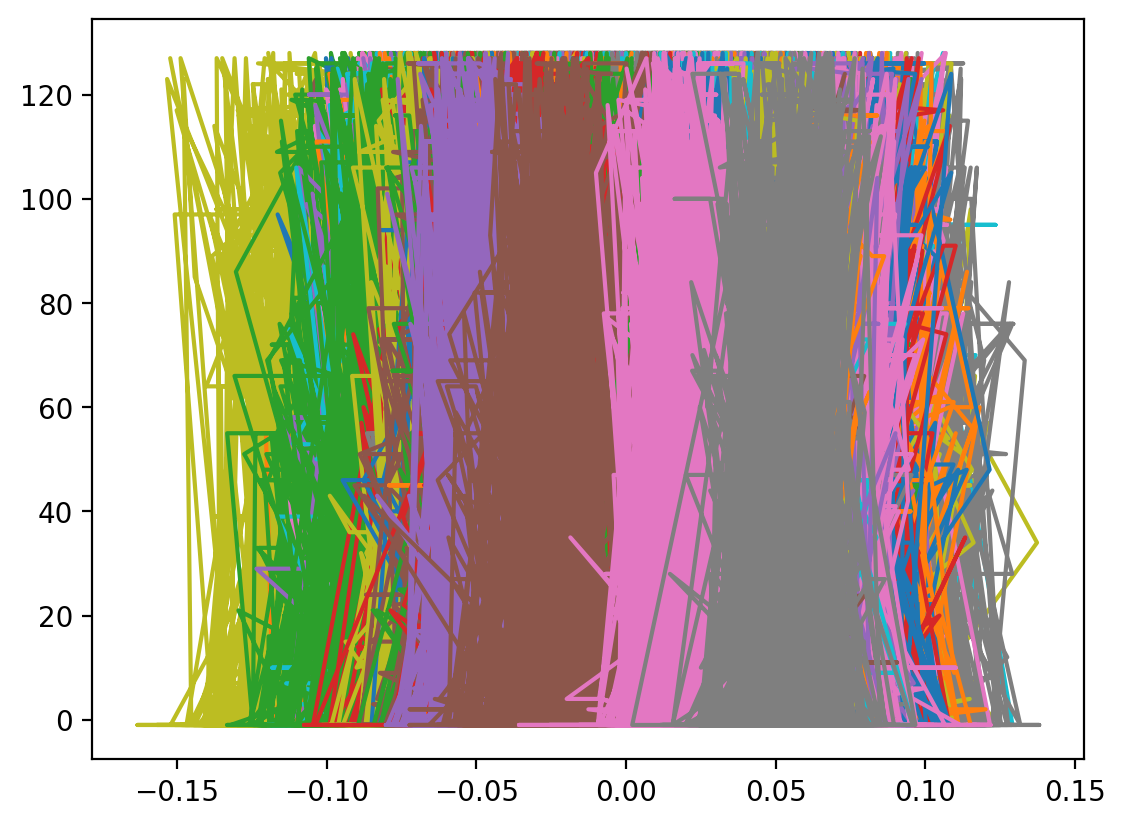

In [64]:
plt.plot(X, hdb.labels_);

#### Dimension reduction for cluster visualisation

Although no dimension reduction was done for calculating the clusters, we can still use it to visualise the data points in 2 dimensions:

TSNE is a dimensionality reduction technique that is better at preserving clusters, whereas PCA is better at preserving distances and therefor the size of differences. Let's compare them:

In [65]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components = 2).fit_transform(np.asarray(X))

In [66]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit_transform(np.asarray(X))

In [67]:
#plotting function from https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html
def clusterplot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

TSNE:

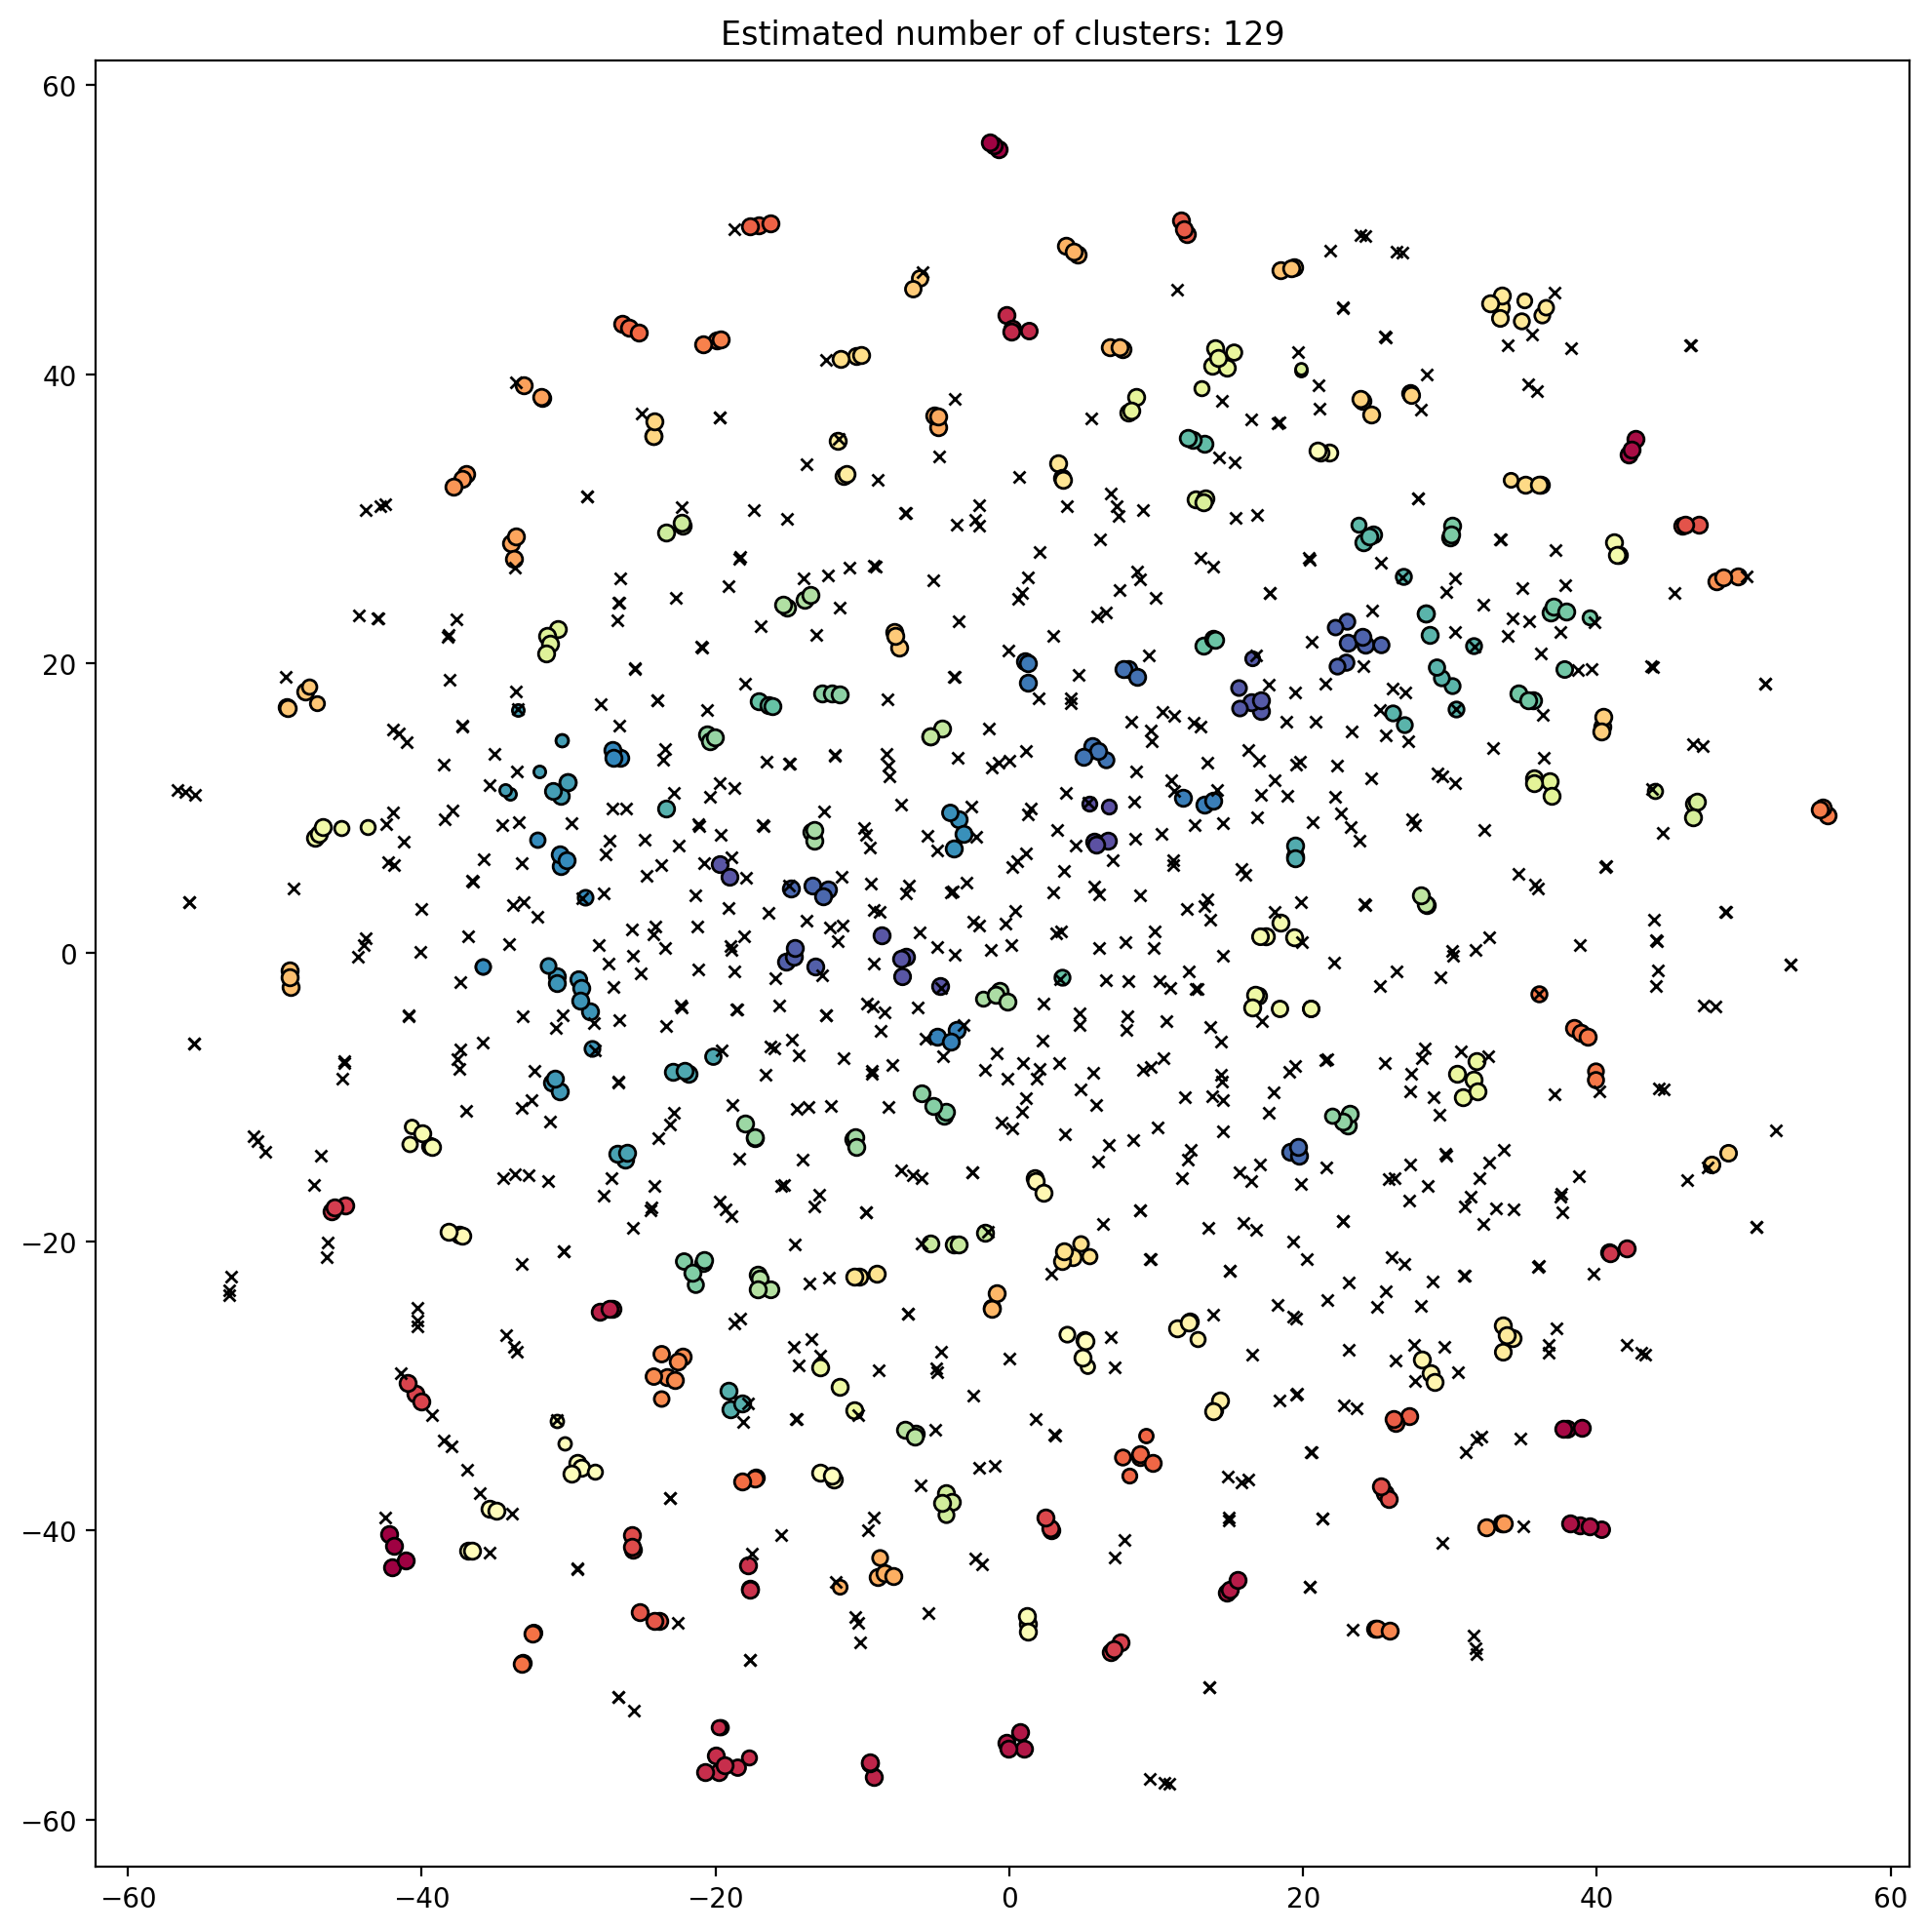

In [68]:
clusterplot(X_tsne, hdb.labels_, hdb.probabilities_)

PCA:

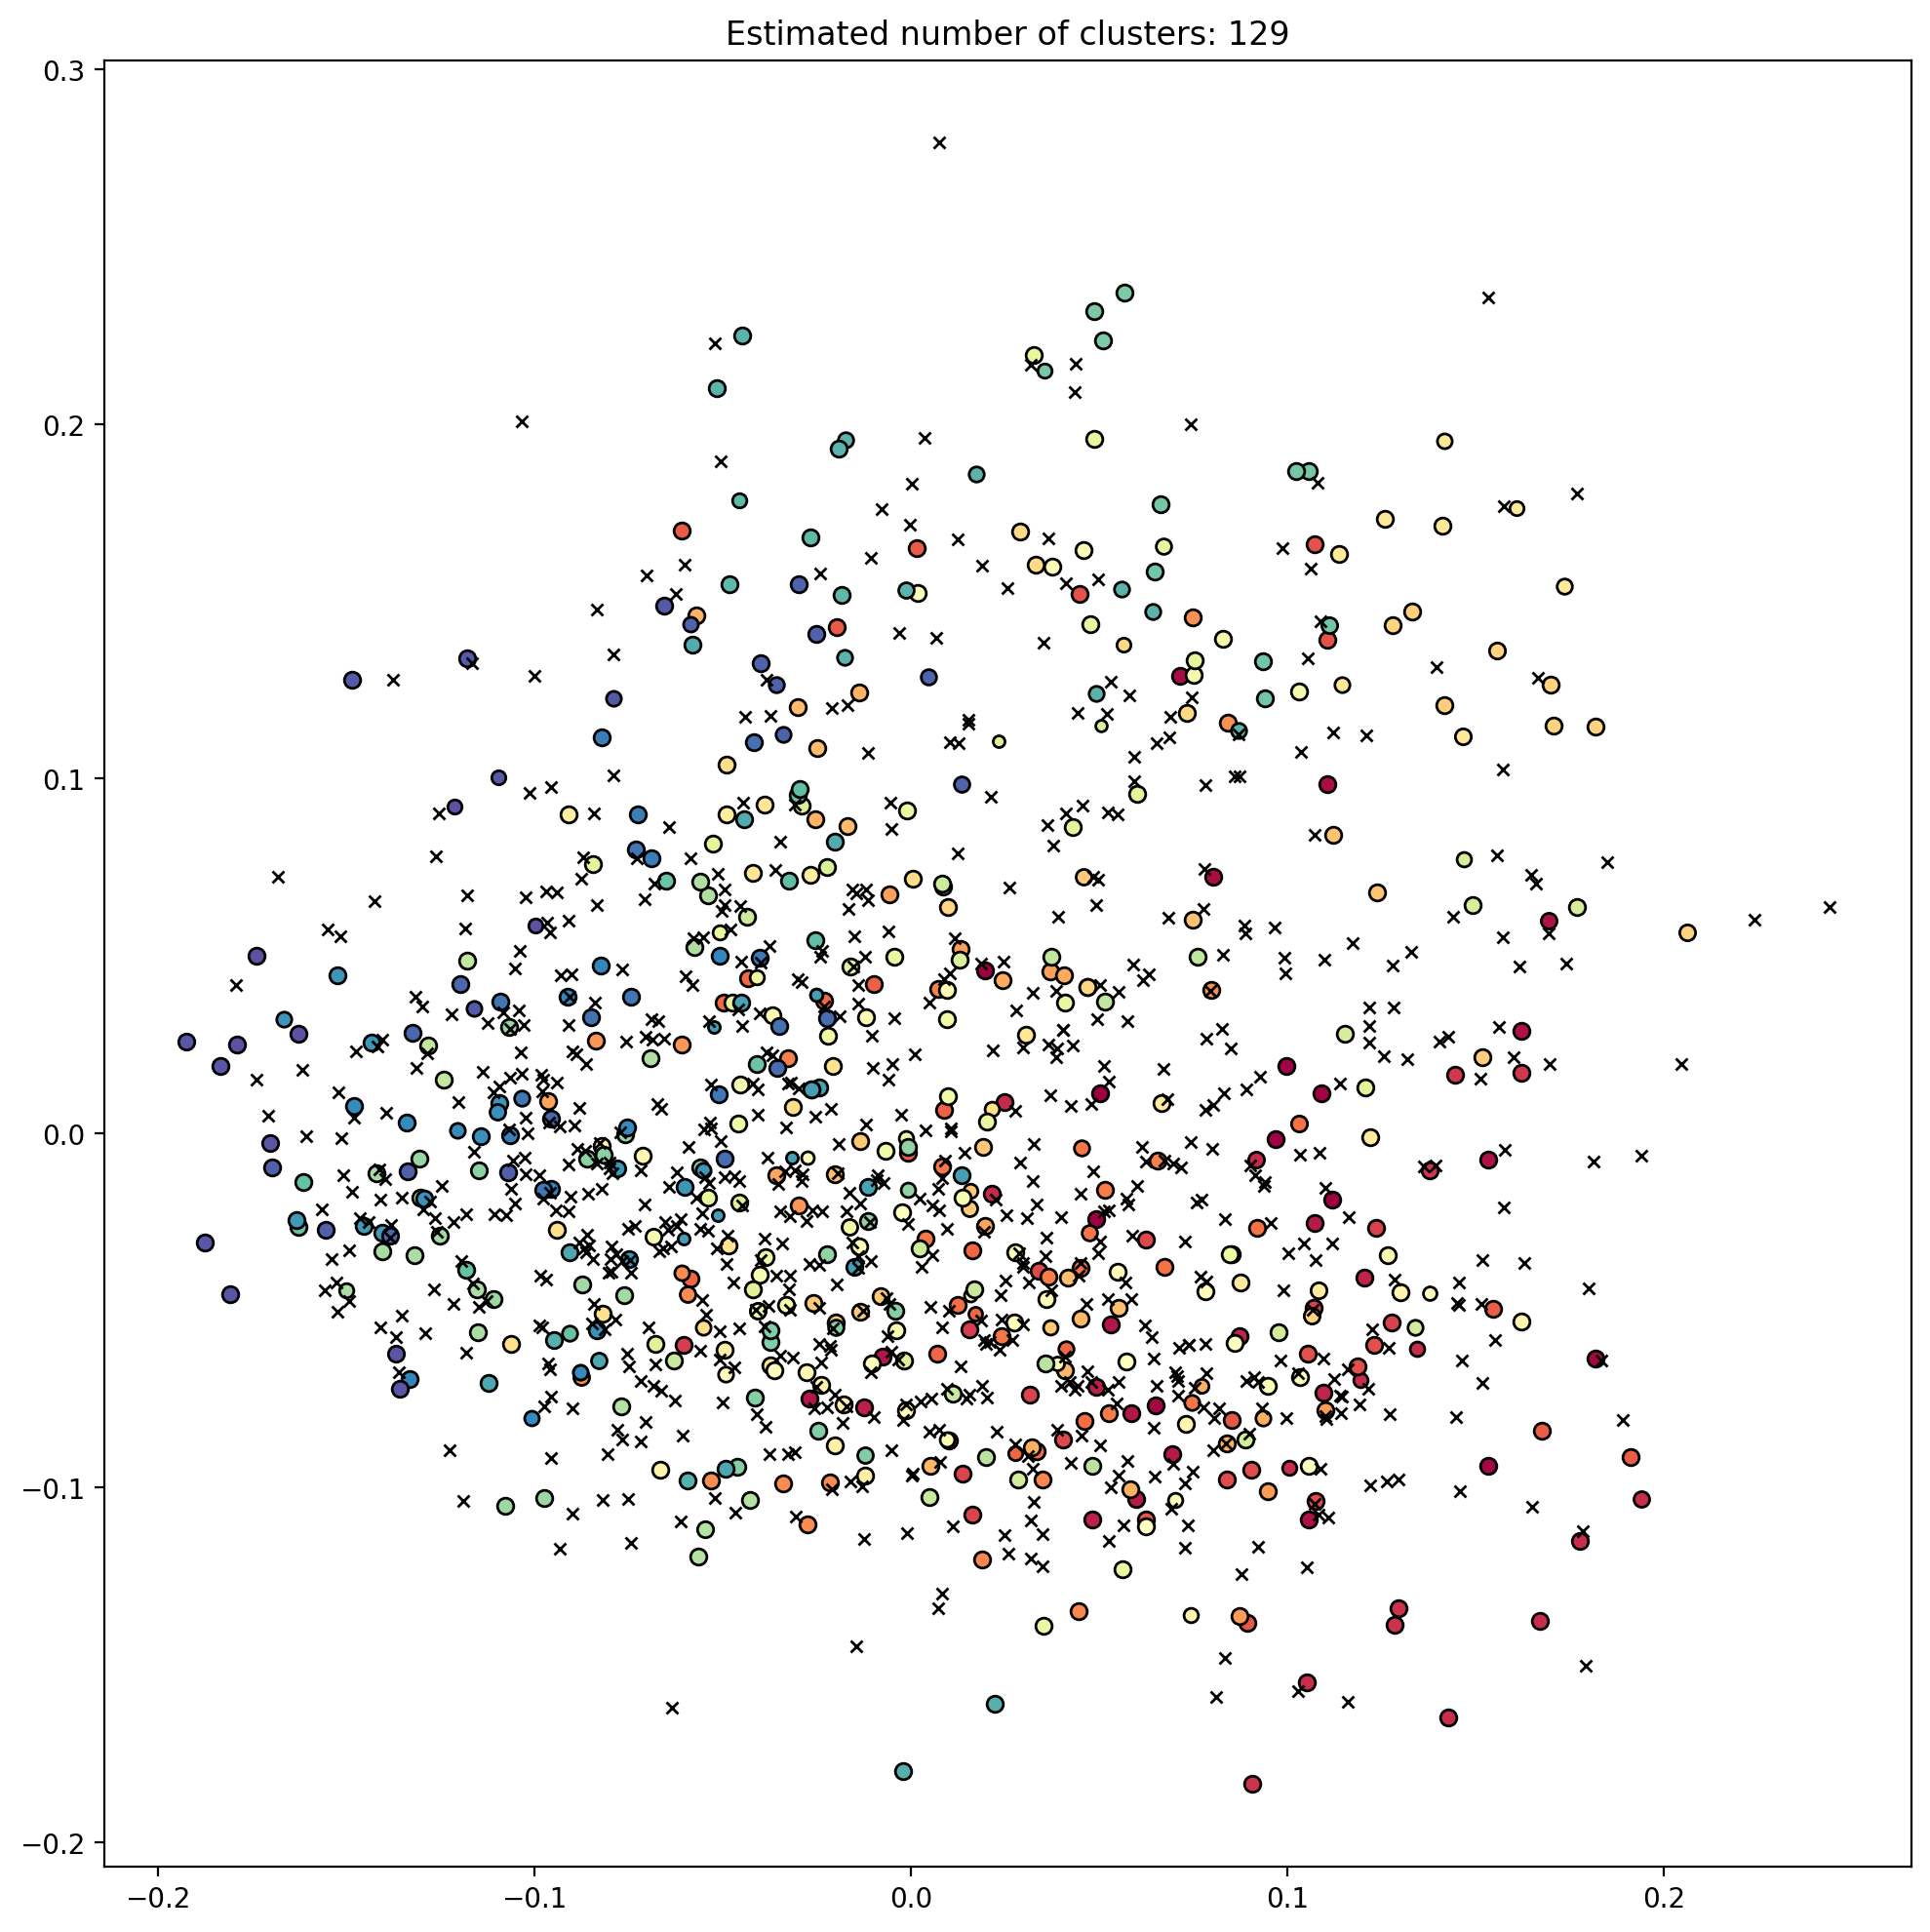

In [69]:
clusterplot(X_pca, hdb.labels_, hdb.probabilities_)

T-SNE seems to produce the best results, but I need to inspect the data to be sure that the clusters reflect the lyrics.

### Compare clusters to Roud numbers

Here are the counts per label:

In [70]:
df_multi_roud_w_embed_label = df_multi_roud_w_embed.copy()
df_multi_roud_w_embed_label = df_multi_roud_w_embed_label.reset_index().join(df_cluster_labels)
df_multi_roud_w_embed_label.sort_values(by=[0])[['name', 'roud', 'probabilities', 0]].groupby([0]).nunique()

,name,roud,probabilities
0,,,
-1,743,241,1
0,4,1,2
1,3,1,1
2,3,1,1
3,3,1,1
...,...,...,...
124,8,1,6
125,4,2,2
126,6,1,4


Let's graph only the songs that got a valid label (not -1):

In [101]:
clusters_v_roud = df_multi_roud_w_embed_label.sort_values(by=[0])[['name', 'roud', 'probabilities', 0]][df_multi_roud_w_embed_label[0] >=0]
clusters_v_roud = clusters_v_roud.rename(columns={0: 'cluster_label'}).sort_values(by='roud')

In [102]:
clusters_v_roud

,name,roud,probabilities,cluster_label
272,Black Jack Davey,1,1.000000,84
280,Blackjack David,1,1.000000,84
279,Blackjack Davey (2),1,1.000000,84
605,The Gypsy Laddie (4),1,0.996968,84
16,The Bold Privateer,1000,1.000000,108
...,...,...,...,...
188,The Agincourt Carole,V29347,1.000000,21
0,The Song of Agincourt,V29347,1.000000,21
41,Drive the Cold Winter Away,V9375,1.000000,38
659,In Praise of Christmas,V9375,1.000000,38


TypeError: set_ticks() missing 1 required positional argument: 'ticks'

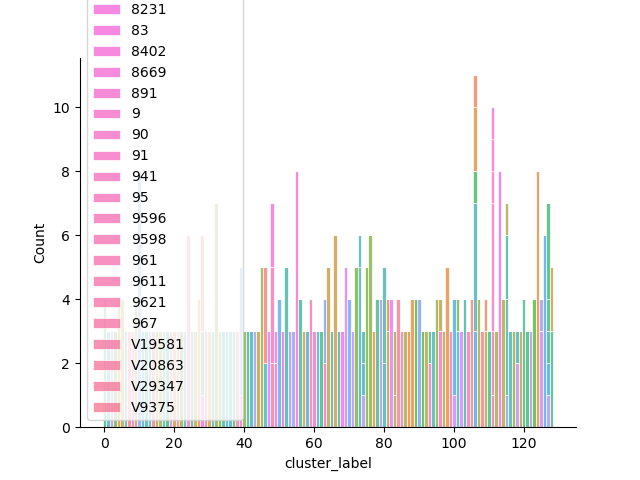

In [164]:
#TODO: add roud label fixed and song label hover
%matplotlib ipympl
fig, ax = plt.subplots()
sns.despine(fig)

hist_plot = sns.histplot(
    clusters_v_roud,
    x='cluster_label', binwidth=1,
    hue='roud',
    discrete=True,
    multiple="stack",
    edgecolor="white",
    linewidth=.5
)
ax.set_xticks(clusters_v_roud.cluster_label)
ax.set_yticks(np.arange(1, 13, step=1))
ax.margins(x=0)

# TODO: Add labels to the 'hue' patches insead of bars 
for bar in ax.containers[0]:  
    height = bar.get_height()
    width = bar.get_width()
    x_pos = bar.get_x() + width / 2
    y_pos = height
    label = clusters_v_roud.loc[clusters_v_roud['cluster_label'] == x_pos, 'roud'].values[0]
    
    ax.text(x_pos, y_pos, label, ha='center', va='bottom', fontsize=6, color='white', rotation='vertical')

ax.get_legend().set_visible(False)

plt.tight_layout()

## Soft clustering

Unfortunately the version of HDBSCAN currently implemented by `sklearn` does not have the `prediction_data=True` parameter which allows us to do soft clustering.

Add features

### experiments

In [74]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# from matplotlib import style

# #%matplotlib inline #added because ipympl was breaking seaborn

# from sklearn import preprocessing, metrics
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Cluster Analysis

# Classification?